# Multi-Modal LLM using Replicate LlaVa and Fuyu 8B model for image reasoning

In this notebook, we show how to use MultiModal LLM class (Llava and Fuyu 8B model from replicate) for image understanding/reasoning


In [ ]:
% pip install replicate

UsageError: Line magic function `%` not found.


## Load and initialize LLava model

In [ ]:
import os

REPLICATE_API_TOKEN = ""  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [ ]:
from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
    load_local_image_files_from_folder,
)

image_documents = load_local_image_files_from_folder("images_wiki")

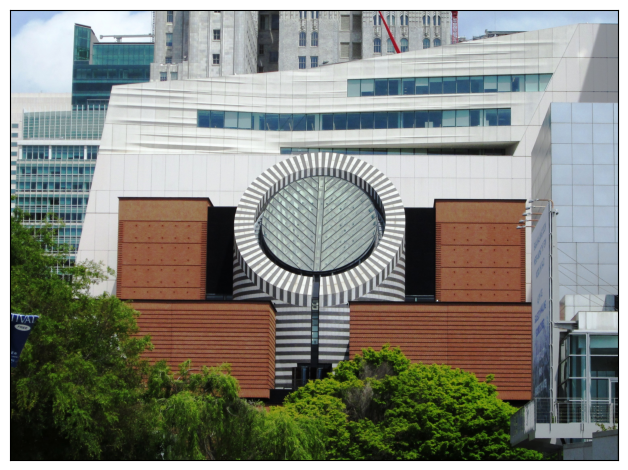

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = image_documents[0].metadata["file_path"]
image = Image.open(img_path).convert("RGB")

# plt.subplot(8, 8, len(original_images_urls) + 1)
plt.imshow(image)
plt.xticks([])
plt.yticks([])


plt.tight_layout()

In [ ]:
from llama_index.multi_modal_llms import ReplicateMultiModal

llava_multi_modal_llm = ReplicateMultiModal(
    model="yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
    max_new_tokens=100,
    temperature=0.1,
    num_input_files=1,
)


llava_resp = llava_multi_modal_llm.complete(
    prompt="what is shown in this image?",
    image_documents=image_documents,
    image_idx=0,
)

In [ ]:
print(llava_resp)

The image shows a large building with a unique circular window, which is a prominent feature of the structure.


## Load and initialize Fuyu-8B model

In [ ]:
# for now fuyu-8b model on replicate can mostly handle JPG image urls well instead of local files
image_urls = [
    "https://www.visualcapitalist.com/wp-content/uploads/2023/10/US_Mortgage_Rate_Surge-Sept-11-1.jpg",
    "https://www.sportsnet.ca/wp-content/uploads/2023/11/CP1688996471-1040x572.jpg",
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg",
    "https://www.cleverfiles.com/howto/wp-content/uploads/2018/03/minion.jpg",
]

image_documents = load_image_urls(image_urls)

In [ ]:
fuyu_multi_modal_llm = ReplicateMultiModal(
    model="lucataco/fuyu-8b:42f23bc876570a46f5a90737086fbc4c3f79dd11753a28eaa39544dd391815e9",
    max_new_tokens=100,
    temperature=0.1,
    num_input_files=1,
)


fuyu_resp = fuyu_multi_modal_llm.complete(
    prompt="what is shown in this image?",
    image_documents=image_documents,
    image_idx=0,
)

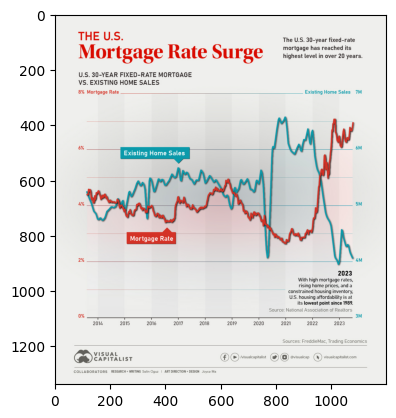

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

response = requests.get(image_urls[0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [ ]:
# Show the image reasoining result from Fuyu 8B model
print(fuyu_resp)

 The mortgage rate has risen from 6% in 2016 to 7.5% in 2017.
